In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import json
import time
import gmaps
from scipy.stats import linregress
from pprint import pprint

covidcasesus_pd = "../Resources/covid_confirmed_usafacts.csv"
covidbycounty_pd = "../Resources/covid_county_population_usafacts.csv"

In [2]:
#Reading covid-19 cases and creating a dataframe 
covidcasesus_pd = pd.read_csv(covidcasesus_pd, encoding="ISO-8859-1")

covidcasesus_pd.head()

,ï»¿countyFIPS,County Name,State,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,0,Statewide Unallocated,AL,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1001,Autauga County,AL,1,0,0,0,0,0,0,...,2021,2023,2030,2048,2059,2074,2082,2103,2126,2141
2,1003,Baldwin County,AL,1,0,0,0,0,0,0,...,6443,6475,6615,6637,6658,6694,6712,6743,6768,6888
3,1005,Barbour County,AL,1,0,0,0,0,0,0,...,996,997,1012,1031,1033,1033,1042,1045,1055,1056
4,1007,Bibb County,AL,1,0,0,0,0,0,0,...,801,811,825,828,840,843,850,856,861,866


In [3]:
#Extracting data on two states of interest and creating a new dataframe with this data
covidcasesus_pd_CA_TX = covidcasesus_pd.set_index("State")

covidcasesus_pd_CA_TX = covidcasesus_pd_CA_TX.loc[["CA","TX"]]

covidcasesus_pd_CA_TX = covidcasesus_pd_CA_TX.reset_index()

covidcasesus_pd_CA_TX.head()

,State,ï»¿countyFIPS,County Name,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,0,Statewide Unallocated,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA,6000,Grand Princess Cruise Ship,6,0,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
2,CA,6001,Alameda County,6,0,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
3,CA,6003,Alpine County,6,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
4,CA,6005,Amador County,6,0,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311


In [4]:
#Checking number of unique counties names to avoide duplicates
covidcasesus_pd_CA_TX["County Name"].nunique()

312

In [5]:
#Checking on duplicates
duplicate = covidcasesus_pd_CA_TX[covidcasesus_pd_CA_TX.duplicated(subset=["County Name"], keep=False)]
duplicate
#There is no "true" duplicates, 2 pairs of counties in both states have the same names + Statewide Unallocated

,State,ï»¿countyFIPS,County Name,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,0,Statewide Unallocated,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,CA,6059,Orange County,6,0,0,0,0,1,1,...,57635,57848,58010,58326,58573,58725,58980,59213,59442,59718
54,CA,6105,Trinity County,6,0,0,0,0,0,0,...,25,25,25,25,25,27,27,28,28,33
60,TX,0,Statewide Unallocated,48,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241,TX,48361,Orange County,48,0,0,0,0,0,0,...,2116,2126,2126,2160,2160,2160,2187,2187,2221,2221
288,TX,48455,Trinity County,48,0,0,0,0,0,0,...,205,205,206,206,206,206,206,206,206,208


In [6]:
#Renaming column in order of future merging two dataframes
covidcasesus_pd_CA_TX = covidcasesus_pd_CA_TX.rename(columns={"ï»¿countyFIPS": "countyFIPS"})
covidcasesus_pd_CA_TX

,State,countyFIPS,County Name,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,0,Statewide Unallocated,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA,6000,Grand Princess Cruise Ship,6,0,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
2,CA,6001,Alameda County,6,0,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
3,CA,6003,Alpine County,6,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
4,CA,6005,Amador County,6,0,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,TX,48499,Wood County,48,0,0,0,0,0,0,...,621,623,626,626,626,633,636,639,655,655
311,TX,48501,Yoakum County,48,0,0,0,0,0,0,...,289,289,289,289,289,289,289,300,304,319
312,TX,48503,Young County,48,0,0,0,0,0,0,...,497,507,521,535,535,535,559,578,591,605
313,TX,48505,Zapata County,48,0,0,0,0,0,0,...,342,342,343,345,346,346,352,352,352,357


In [7]:
#Reading a data with counties population across USA
covidbycounty_pd = pd.read_csv(covidbycounty_pd, encoding="ISO-8859-1")

covidbycounty_pd.head()

,countyFIPS,County Name,State,population
0,0,Statewide Unallocated,AL,0
1,1001,Autauga County,AL,55869
2,1003,Baldwin County,AL,223234
3,1005,Barbour County,AL,24686
4,1007,Bibb County,AL,22394


In [8]:
#Extracting data on states of interest 
#(maybe change name of this dataframe? It`s just about population, not covid)
covidbycounty_pd_CA_TX = covidbycounty_pd.set_index("State")

covidbycounty_pd_CA_TX = covidbycounty_pd_CA_TX.loc[["CA","TX"]]

covidbycounty_pd_CA_TX = covidbycounty_pd_CA_TX.reset_index()

covidbycounty_pd_CA_TX.head()

,State,countyFIPS,County Name,population
0,CA,0,Statewide Unallocated,0
1,CA,6000,Grand Princess Cruise Ship,0
2,CA,6001,Alameda County,1671329
3,CA,6003,Alpine County,1129
4,CA,6005,Amador County,39752


In [9]:
#Merging two dataframes, keeping in mind that there is counties with the same names in Texas and California
covid_complete_CA_TX = pd.merge(covidbycounty_pd_CA_TX, covidcasesus_pd_CA_TX, how="left", on=["State", "countyFIPS", "County Name"])
covid_complete_CA_TX

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,0,Statewide Unallocated,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA,6000,Grand Princess Cruise Ship,0,6,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
2,CA,6001,Alameda County,1671329,6,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
3,CA,6003,Alpine County,1129,6,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
4,CA,6005,Amador County,39752,6,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,TX,48499,Wood County,45539,48,0,0,0,0,0,...,621,623,626,626,626,633,636,639,655,655
311,TX,48501,Yoakum County,8713,48,0,0,0,0,0,...,289,289,289,289,289,289,289,300,304,319
312,TX,48503,Young County,18010,48,0,0,0,0,0,...,497,507,521,535,535,535,559,578,591,605
313,TX,48505,Zapata County,14179,48,0,0,0,0,0,...,342,342,343,345,346,346,352,352,352,357


In [10]:
#Checking on duplicates
duplicate = covid_complete_CA_TX[covid_complete_CA_TX.duplicated(subset=["County Name"], keep=False)]
duplicate
#There is no "true" duplicates, 2 pairs of counties in both states have the same names + Statewide Unallocated

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,0,Statewide Unallocated,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
31,CA,6059,Orange County,3175692,6,0,0,0,0,1,...,57635,57848,58010,58326,58573,58725,58980,59213,59442,59718
54,CA,6105,Trinity County,12285,6,0,0,0,0,0,...,25,25,25,25,25,27,27,28,28,33
60,TX,0,Statewide Unallocated,0,48,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
241,TX,48361,Orange County,83396,48,0,0,0,0,0,...,2116,2126,2126,2160,2160,2160,2187,2187,2221,2221
288,TX,48455,Trinity County,14651,48,0,0,0,0,0,...,205,205,206,206,206,206,206,206,206,208


In [11]:
#Including that there is no infection in "Statewide Unallocated" - 
#dropping this two rows
covid_clean_CA_TX = covid_complete_CA_TX.drop([0, 60])

covid_clean_CA_TX

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
1,CA,6000,Grand Princess Cruise Ship,0,6,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
2,CA,6001,Alameda County,1671329,6,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
3,CA,6003,Alpine County,1129,6,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
4,CA,6005,Amador County,39752,6,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311
5,CA,6007,Butte County,219186,6,0,0,0,0,0,...,3018,3030,3047,3047,3047,3073,3073,3113,3127,3144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,TX,48499,Wood County,45539,48,0,0,0,0,0,...,621,623,626,626,626,633,636,639,655,655
311,TX,48501,Yoakum County,8713,48,0,0,0,0,0,...,289,289,289,289,289,289,289,300,304,319
312,TX,48503,Young County,18010,48,0,0,0,0,0,...,497,507,521,535,535,535,559,578,591,605
313,TX,48505,Zapata County,14179,48,0,0,0,0,0,...,342,342,343,345,346,346,352,352,352,357


In [12]:
#Looking into the data
covid_clean_CA_TX.describe()

,countyFIPS,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
count,313.000000,3.130000e+02,313.000000,313.0,313.0,313.0,313.0,313.000000,313.000000,313.000000,...,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000,313.000000
mean,40299.936102,2.188757e+05,40.083067,0.0,0.0,0.0,0.0,0.006390,0.009585,0.009585,...,5551.367412,5593.351438,5631.888179,5666.677316,5686.996805,5718.511182,5755.853035,5787.792332,5822.856230,5860.980831
std,16530.610249,7.603383e+05,16.452909,0.0,0.0,0.0,0.0,0.079808,0.097587,0.097587,...,21281.105200,21489.826143,21656.729017,21796.359376,21880.273206,21966.562313,22074.446762,22168.946635,22294.570729,22402.473130
min,6000.000000,0.000000e+00,6.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48039.000000,8.175000e+03,48.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,154.000000,157.000000,157.000000,158.000000,158.000000,158.000000,161.000000,164.000000,165.000000,166.000000
50%,48195.000000,2.302100e+04,48.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,539.000000,542.000000,543.000000,545.000000,545.000000,545.000000,559.000000,561.000000,569.000000,571.000000
75%,48351.000000,9.324500e+04,48.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,2116.000000,2126.000000,2126.000000,2160.000000,2160.000000,2160.000000,2187.000000,2187.000000,2221.000000,2221.000000
max,48507.000000,1.003911e+07,48.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,...,290486.000000,294065.000000,296821.000000,298937.000000,299760.000000,300614.000000,302077.000000,303369.000000,305070.000000,306327.000000


In [13]:
#Comparing population CA and TX
population = covid_clean_CA_TX.groupby("State")["population"].sum()
population

State
CA    39512223
TX    28995881
Name: population, dtype: int64

Text(0, 0.5, 'Population')

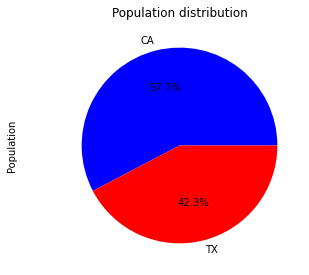

In [14]:
#Comparing population CA and TX using pie chart
population_distribution = population.plot(kind="pie", y="State", autopct="%1.1f%%",
                                      colors = ["blue", "red"], title="Population distribution",
                                          figsize=(4.5, 4.5))
population_distribution.set_ylabel("Population", labelpad=40)

In [15]:
#Comparing quantity of infected with covid-19 CA and TX
infection = covid_clean_CA_TX.groupby("State")["10/30/2020"].sum()
infection

State
CA    928644
TX    905843
Name: 10/30/2020, dtype: int64

Text(0, 0.5, 'Infection')

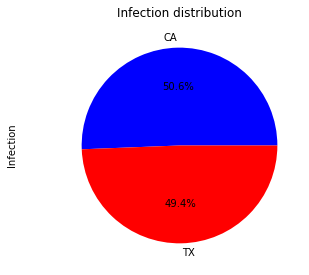

In [16]:
#Comparing quantity of infected with covid-19 CA and TX using pie chart
infection_distribution = infection.plot(kind="pie", y="State", autopct="%1.1f%%",
                                      colors = ["blue", "red"], title="Infection distribution",
                                          figsize=(4.5, 4.5))
infection_distribution.set_ylabel("Infection", labelpad=40)

In [58]:
# covid_complete_clean = covid_complete.drop(columns=["State_y","countyFIPS"])
# covid_complete_clean.head()

,State_x,County Name,population,ï»¿countyFIPS,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
0,CA,Statewide Unallocated,0,0,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CA,Statewide Unallocated,0,0,48,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CA,Grand Princess Cruise Ship,0,6000,6,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
3,CA,Alameda County,1671329,6001,6,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
4,CA,Alpine County,1129,6003,6,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3


In [79]:
# covid_complete_clean_CA_TX = covid_complete_clean.set_index("State_x")
# covid_complete_clean_CA = covid_complete_clean_CA_TX.loc["CA"]
# covid_complete_clean_CA = covid_complete_clean_CA[["County Name","population"]].sort_values("population", ascending=False).drop_duplicates()
# covid_complete_clean_CA
# covid_complete_clean_CA.plot (kind = "bar", x = "County Name", y = "population")

,County Name,population
State_x,,
CA,Los Angeles County,10039107
CA,San Diego County,3338330
CA,Orange County,3175692
CA,Riverside County,2470546
CA,San Bernardino County,2180085
CA,Santa Clara County,1927852
CA,Alameda County,1671329
CA,Sacramento County,1552058
CA,Contra Costa County,1153526


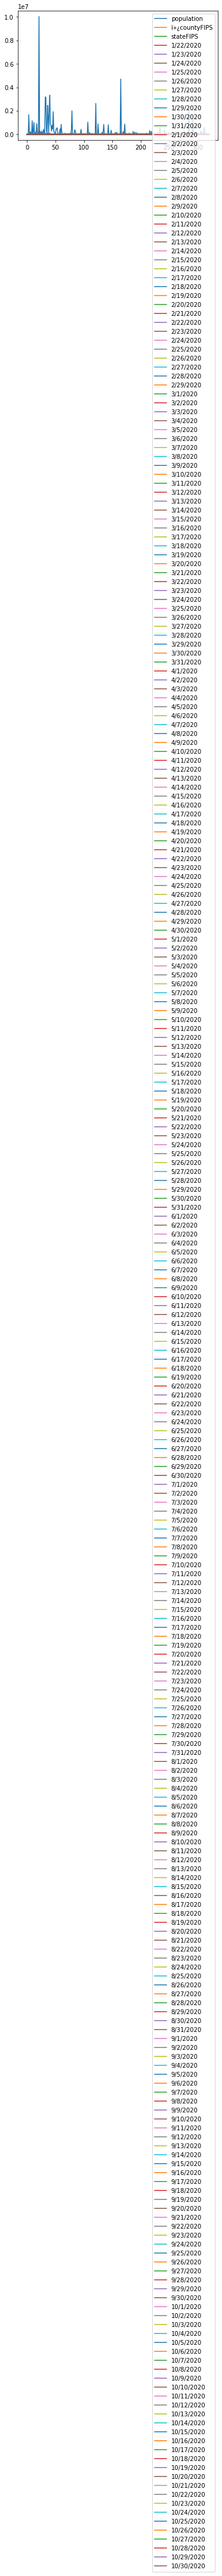

In [55]:
covid_complete_clean.plot (kind="line")

In [17]:
covid_clean_CA_TX

,State,countyFIPS,County Name,population,stateFIPS,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
1,CA,6000,Grand Princess Cruise Ship,0,6,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
2,CA,6001,Alameda County,1671329,6,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
3,CA,6003,Alpine County,1129,6,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
4,CA,6005,Amador County,39752,6,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311
5,CA,6007,Butte County,219186,6,0,0,0,0,0,...,3018,3030,3047,3047,3047,3073,3073,3113,3127,3144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,TX,48499,Wood County,45539,48,0,0,0,0,0,...,621,623,626,626,626,633,636,639,655,655
311,TX,48501,Yoakum County,8713,48,0,0,0,0,0,...,289,289,289,289,289,289,289,300,304,319
312,TX,48503,Young County,18010,48,0,0,0,0,0,...,497,507,521,535,535,535,559,578,591,605
313,TX,48505,Zapata County,14179,48,0,0,0,0,0,...,342,342,343,345,346,346,352,352,352,357


In [20]:
#Getting the column names to drop for better data
covid_clean_CA_TX.columns

Index(['State', 'countyFIPS', 'County Name', 'population', 'stateFIPS',
       '1/22/2020', '1/23/2020', '1/24/2020', '1/25/2020', '1/26/2020',
       ...
       '10/21/2020', '10/22/2020', '10/23/2020', '10/24/2020', '10/25/2020',
       '10/26/2020', '10/27/2020', '10/28/2020', '10/29/2020', '10/30/2020'],
      dtype='object', length=288)

In [24]:
#drop unnecessary column and just get the cases and state
daily_cases= covid_clean_CA_TX.drop(columns=['countyFIPS','County Name','stateFIPS','population'])
daily_cases

,State,1/22/2020,1/23/2020,1/24/2020,1/25/2020,1/26/2020,1/27/2020,1/28/2020,1/29/2020,1/30/2020,...,10/21/2020,10/22/2020,10/23/2020,10/24/2020,10/25/2020,10/26/2020,10/27/2020,10/28/2020,10/29/2020,10/30/2020
1,CA,0,0,0,0,0,0,0,0,0,...,21,21,21,21,21,21,21,21,21,21
2,CA,0,0,0,0,0,0,0,0,0,...,22932,23001,23133,23215,23312,23391,23391,23576,23636,23775
3,CA,0,0,0,0,0,0,0,0,0,...,3,3,3,3,3,3,3,3,3,3
4,CA,0,0,0,0,0,0,0,0,0,...,276,287,291,291,291,299,301,302,308,311
5,CA,0,0,0,0,0,0,0,0,0,...,3018,3030,3047,3047,3047,3073,3073,3113,3127,3144
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310,TX,0,0,0,0,0,0,0,0,0,...,621,623,626,626,626,633,636,639,655,655
311,TX,0,0,0,0,0,0,0,0,0,...,289,289,289,289,289,289,289,300,304,319
312,TX,0,0,0,0,0,0,0,0,0,...,497,507,521,535,535,535,559,578,591,605
313,TX,0,0,0,0,0,0,0,0,0,...,342,342,343,345,346,346,352,352,352,357


In [39]:
#tranpose the columns and rows 
daily_cases=daily_cases.set_index("State")
new_transpose1=daily_cases.T
new_transpose1



State,CA,CA,CA,CA,CA,CA,CA,CA,CA,CA,...,TX,TX,TX,TX,TX,TX,TX,TX,TX,TX
1/22/2020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/23/2020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/24/2020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/25/2020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1/26/2020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10/26/2020,21,23391,3,299,3073,342,551,18763,180,1351,...,1228,9335,998,140,908,633,289,535,346,461
10/27/2020,21,23391,3,301,3073,342,551,18763,180,1351,...,1231,9418,1000,142,925,636,289,559,352,463
10/28/2020,21,23576,3,302,3113,347,553,18877,180,1368,...,1232,9479,1003,149,930,639,300,578,352,466
10/29/2020,21,23636,3,308,3127,347,555,18981,181,1380,...,1232,9509,1006,150,944,655,304,591,352,469


In [43]:
#daily cases by county
daily_cases_by_county=new_transpose1.diff()
daily_cases_by_county

State,CA,CA,CA,CA,CA,CA,CA,CA,CA,CA,...,TX,TX,TX,TX,TX,TX,TX,TX,TX,TX
1/22/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1/23/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/24/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/25/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1/26/2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10/26/2020,0.0,79.0,0.0,8.0,26.0,0.0,1.0,69.0,2.0,36.0,...,0.0,0.0,7.0,0.0,0.0,7.0,0.0,0.0,0.0,1.0
10/27/2020,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,83.0,2.0,2.0,17.0,3.0,0.0,24.0,6.0,2.0
10/28/2020,0.0,185.0,0.0,1.0,40.0,5.0,2.0,114.0,0.0,17.0,...,1.0,61.0,3.0,7.0,5.0,3.0,11.0,19.0,0.0,3.0
10/29/2020,0.0,60.0,0.0,6.0,14.0,0.0,2.0,104.0,1.0,12.0,...,0.0,30.0,3.0,1.0,14.0,16.0,4.0,13.0,0.0,3.0


In [47]:
#group by state
group_by_state=daily_cases.groupby(["State"]).sum()
new_transpose2=group_by_state.T
new_transpose2

State,CA,TX
1/22/2020,0,0
1/23/2020,0,0
1/24/2020,0,0
1/25/2020,0,0
1/26/2020,2,0
...,...,...
10/26/2020,910880,879014
10/27/2020,915400,886182
10/28/2020,919593,891986
10/29/2020,923502,899052


In [48]:
#daily cases by state
daily_cases_by_state=new_transpose2.diff()
daily_cases_by_state

State,CA,TX
1/22/2020,NaN,NaN
1/23/2020,0.0,0.0
1/24/2020,0.0,0.0
1/25/2020,0.0,0.0
1/26/2020,2.0,0.0
...,...,...
10/26/2020,5137.0,4727.0
10/27/2020,4520.0,7168.0
10/28/2020,4193.0,5804.0
10/29/2020,3909.0,7066.0


In [69]:
#scatter plot for daily cases by state
CA_daily_cases= daily_cases_by_state["CA"]
TX_daily_cases=daily_cases_by_state["TX"]

#setting the index as column in order to plot
daily_cases_by_state["Date"]=daily_cases_by_state.index
daily_cases_by_state
date_daily_cases=daily_cases_by_state["Date"]


<function matplotlib.pyplot.show(close=None, block=None)>

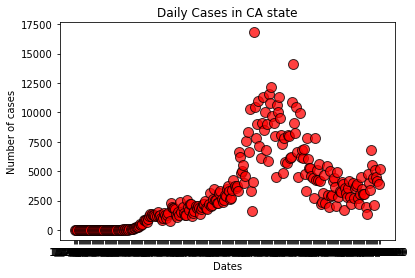

In [70]:
#plot scatter
fig, ax=plt.subplots()
ax.scatter(date_daily_cases, CA_daily_cases, marker="o", facecolors="red", edgecolors="black", alpha=0.75,s=100)
plt.title("Daily Cases in CA state")
plt.xlabel("Dates")
plt.ylabel("Number of cases")
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

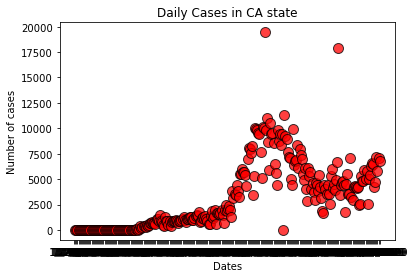

In [71]:
#plt scatter for TX
fig1, ax1=plt.subplots()
ax1.scatter(date_daily_cases, TX_daily_cases, marker="o", facecolors="red", edgecolors="black", alpha=0.75,s=100)
plt.title("Daily Cases in CA state")
plt.xlabel("Dates")
plt.ylabel("Number of cases")
plt.show